In [1]:
#hide
from fastai2.vision.all import *
from utils import *

matplotlib.rc('image', cmap='Greys')

# fast.ai Chapter 4

# Further research questions

## First research question

> Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.

The learner takes the following inputs:

- DataLoaders
- the model 
- the optimization function 
- the loss function
- optionally any metrics to print

I'll recreate the `fast.ai` `Learner` by using the data from the chapter: identifying 3's from 7's.

### Create the DataLoaders

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

Now we can read each image and then convert it to a tensor:

In [3]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]

valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])

valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])

We normalize the pixels by dividing them by 255:

In [4]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

valid_3_tens = valid_3_tens.float()/255
valid_7_tens = valid_7_tens.float()/255

We can then put all of the training images on a rank 2 tensor:

In [5]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)

For the labels, we put them in a column vector:

In [6]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)

Finally, we put both of these tensors in the dataLoaders:

In [7]:
dset = list(zip(train_x,train_y))
dl = DataLoader(dset, batch_size=256)

valid_dset = list(zip(valid_x,valid_y))
valid_dl = DataLoader(valid_dset, batch_size=256)

dls = DataLoaders(dl, valid_dl)

### Create the model

Remember: a neural network is just a composition of a linear function and some activation function: many times over.

In [8]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1),
    nn.Sigmoid()
)

### Create the optimization function

`fastai` already comes with its own `SGD` optimizer:

In [9]:
SGD

<function fastai2.optimizer.SGD(params, lr, mom=0.0, wd=0.0, decouple_wd=True)>

### Loss function

`pytorch` already has an implementation of the cross entropy loss function that we use in binary classification problems:

In [10]:
nn.BCELoss()

BCELoss()

### Metrics to print

We will print the accuracy on the validation set

## Putting it all together in the learner

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
class Learner():
    
    def __init__(self, dataloaders, model, opt, loss):
        
        self.train_dl = dataloaders[0]
        self.valid_dl = dataloaders[1]
        self.model = model
        self.opt = opt(self.model.parameters(), lr=0.1)
        self.loss = loss
        
    def batch_accuracy(self, preds, yb):
        
        correct = (preds>0.5) == yb
        return correct.float().mean()
        
    def validate_epoch(self):
        
        accs = [self.batch_accuracy(self.model(xb), yb) for xb,yb in self.valid_dl]
        return round(torch.stack(accs).mean().item(), 4)
        
    def train_epoch(self):
        
        for xb,yb in self.train_dl:
            preds = self.model(xb)
            calculated_loss = self.loss(preds, yb*1.0)
            calculated_loss.backward()
            self.opt.step()
            self.opt.zero_grad()
                
    def fit(self, n):
        
        for epoch in range(n):
            self.train_epoch()
            print(self.validate_epoch(), end=' ')

## Taking our learner for a spin

We can train test our learner on the data for 3's and 7's:

In [13]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1),
    nn.Sigmoid()
)

In [14]:
example = Learner(dls, simple_net, SGD, nn.BCELoss())
example.fit(40)

0.5068 0.7793 0.9033 0.9297 0.9434 0.9516 0.9565 0.9599 0.9653 0.9658 0.9658 0.9678 0.9687 0.9692 0.9697 0.9707 0.9721 0.9726 0.9731 0.9736 0.9741 0.9746 0.9741 0.9746 0.9751 0.9756 0.9761 0.9765 0.977 0.9765 0.9775 0.978 0.978 0.978 0.978 0.978 0.978 0.979 0.9795 0.9799 

## Second Research Question

> Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.

### Getting the data

In [15]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('C:/Users/57319/.fastai/data/mnist_png/testing'),Path('C:/Users/57319/.fastai/data/mnist_png/training')]

We can use the `DataBlock` API to read both the train and test folders. 

In [16]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(train_name='training', valid_name='testing'),
                  get_y=parent_label)

In [17]:
dls = mnist.dataloaders(path, num_workers = 0)

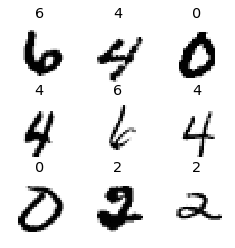

In [18]:
dls.show_batch(max_n=9, figsize=(4,4))

We must modify our sequential model to first *flatten* the 28x28 images that we just loaded. Also, we **must output in the final layer 10 activations**

In [19]:
simple_net = nn.Sequential(
    Flatten(),
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30, 10)
)

Also, we must **change our loss function and our definition of accuracy now that we have a multi-class problem**

In [20]:
class Learner():
    
    def __init__(self, dataloaders, model, opt, loss):
        
        self.train_dl = dataloaders[0]
        self.valid_dl = dataloaders[1]
        self.model = model
        self.opt = opt(self.model.parameters(), lr=0.1)
        self.loss = loss
        
    def train_epoch(self):
                
        for xb,yb in self.train_dl:
            preds = self.model(xb)
            calculated_loss = self.loss(preds, yb.long())
            calculated_loss.backward()
            self.opt.step()
            self.opt.zero_grad()
            
            
    def batch_accuracy(self, preds, yb):
        
        probs = torch.softmax(preds, dim=1)
        winners = probs.argmax(dim=1)
        corrects = (winners == yb)
        accuracy = corrects.sum().float() / float( yb.size(0) )
        return accuracy

        
    def validate_epoch(self):
        
        accs = [self.batch_accuracy(self.model(xb), yb) for xb,yb in self.valid_dl]
        return round(torch.stack(accs).mean().item(), 4)
                            
    def fit(self, n):
        
        for epoch in range(n):
            self.train_epoch()
            print(self.validate_epoch(), end=' ')

In [21]:
mnist_learner = Learner(dls, simple_net.to(device), SGD, nn.CrossEntropyLoss())
mnist_learner.fit(10)

0.9179 0.9398 0.9487 0.9538 0.9584 0.9602 0.9606 0.9635 0.9645 0.9664 

96% accuracy! not that bad for such a simple model.